Steps for clustering algorithm (what has been done manually and now needs to be automated)

1. Seasonality : 4 hour window periods
2. Standard deviation for 4 hour periods
3. Timestamps matched for carbohydrate intake (i.e. all 35g CHO within 1 hour of eachother grouped together)
4. Rate of glucose appearance and disappearance

    a. Glucose excursion (nadir to peak / peak to nadir) - +ve and -ve trends

    b. iAUC (nadir to peak / peak to nadir) - +ve and -ve trends
    
5. Total change in BG (nadir to peak / peak to nadir) - +ve and -ve 

6. Incude the Carbs consumed in the 4 hour period

7. Collate the results of the above points into a data set with columns names

- Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)
- Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
- Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
- Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
- Time period Number (1 / 2 / 3 / 4 / 5)
- iAUC (+ve)
- iAUC (-ve)
- Glucose Excursion (+ve)
- Glucose Excursion (-ve)
- Total change in BG (+ve)
- Total change in BG (-ve)
- Peak value
- Carbs

8. Run Clustering Algorithm

9. Goodness of fit assessment :

- Want the algorithm to be adaptive.

    Have the left overs recycled through the 'rules' missing the glucose excursion but maintaining the iAUC and total change in BG. 
    
    Then further iterations miss out the iAUC and review total change in BG etc

First things first:
Import/load necessary libraries 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime, date
import calendar
import time

from datetime import timedelta #MHA
from statistics import mode

%matplotlib inline

Load and preprocess necessary data sets

In [14]:
# Import data
unfiltered = pd.read_csv('./CSV Files/544_data.csv')
unfiltered['glucose_level_ts'] = pd.to_datetime(unfiltered['glucose_level_ts'], format="%d/%m/%Y %H:%M")
unfiltered.drop('glucose_level_mmol/L', axis=1)

,glucose_level_ts,glucose_level_mg/dL,carbs_g,meal_ts,meal_type,bolus_dose,bolus_start_ts,bolus_end_ts,bolus_type
0,2020-05-11 00:02:00,129,135.0,11/05/2020 11:25,Lunch,7.1,11/05/2020 08:24,11/05/2020 08:24,normal
1,2020-05-11 00:07:00,128,100.0,11/05/2020 17:16,Dinner,16.8,11/05/2020 11:24,11/05/2020 11:24,normal
2,2020-05-11 00:12:00,129,42.0,11/05/2020 21:26,Snack,14.2,11/05/2020 17:19,11/05/2020 17:19,normal
3,2020-05-11 00:17:00,131,37.0,12/05/2020 08:02,Breakfast,7.5,11/05/2020 21:23,11/05/2020 21:23,normal
4,2020-05-11 00:22:00,133,78.0,12/05/2020 12:07,Lunch,6.9,12/05/2020 08:00,12/05/2020 08:00,normal
...,...,...,...,...,...,...,...,...,...
13334,2020-07-04 20:57:00,296,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13335,2020-07-04 21:02:00,292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13336,2020-07-04 21:07:00,284,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13337,2020-07-04 21:12:00,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Here we filter the unfiltered for glucose level and glucose_ts to use in isolating the glucose events.
# We will pick up the unfiltered datset again later whenlooking at CHO and Insulin Levels

features = ['glucose_level_ts', 'glucose_level_mg/dL']
data = unfiltered[features].copy()

# Convert timestamp to datetime format
data['glucose_level_ts'] = pd.to_datetime(data['glucose_level_ts'])

# Remove the first row
data = data.iloc[1:].reset_index(drop=True)

# Map day of week names to day of week numbers
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 7: 'Sunday'}
data['day_of_week'] = data['glucose_level_ts'].dt.dayofweek.map(day_names)


# MHA: make sure time series is (roughly) uniform
time_step = mode(data['glucose_level_ts'].diff())
time_step_minutes = time_step/timedelta(minutes=1)
assert(time_step_minutes == 5)

date_index = pd.date_range(start=min(data['glucose_level_ts']), end=max(data['glucose_level_ts']),freq=time_step)
data = data.reset_index() # store original index, just in case
data = data.set_index(data['glucose_level_ts'])
data = data.reindex(date_index, method='nearest', tolerance = time_step)
data = data.reset_index(drop=True)

# Calculate rate of change
data['BG Rate of Change'] = data['glucose_level_mg/dL'].diff()/time_step_minutes

data

# plt.plot(data['glucose_level_mg/dL'])   

,index,glucose_level_ts,glucose_level_mg/dL,day_of_week,BG Rate of Change
0,0.0,2020-05-11 00:07:00,128.0,Monday,NaN
1,1.0,2020-05-11 00:12:00,129.0,Monday,0.2
2,2.0,2020-05-11 00:17:00,131.0,Monday,0.4
3,3.0,2020-05-11 00:22:00,133.0,Monday,0.4
4,4.0,2020-05-11 00:27:00,132.0,Monday,-0.2
...,...,...,...,...,...
15802,13333.0,2020-07-04 20:57:00,296.0,Saturday,0.0
15803,13334.0,2020-07-04 21:02:00,292.0,Saturday,-0.8
15804,13335.0,2020-07-04 21:07:00,284.0,Saturday,-1.6
15805,13336.0,2020-07-04 21:12:00,273.0,Saturday,-2.2


Step 2:

Isolate the peak and nadir (low) points in the set windows

Found 190 peaks
Found 143 throughs


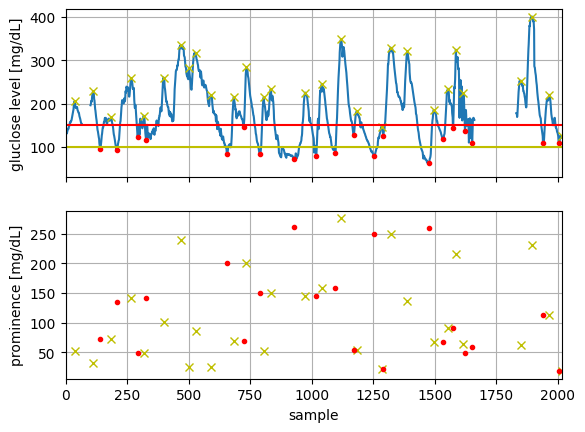

In [16]:
# Convert data to numpy arrays
glucose_level_ts = data['glucose_level_ts'] # MHA: added type
glucose_level = np.array(data['glucose_level_mg/dL'], dtype=float)
glucose_change = np.array(data['BG Rate of Change'], dtype=float)

# Set threshold values for glycemic events
glucose_threshold_high = 100  # mg/dL (5.5 mmol/L) # MHA: changed this just to make it visible in the plot
glucose_threshold_low = 150 # mg/dL (5.5 mmol/L)
rate_of_change_threshold = 0 # mg/dL/min (0.3 mmol/L)   # MHA: see note below (*)

# MHA ----

# I set here the value you had for `rate_of_change_threshold`.
# the difference is that, this way, the peak must be `prominence` units above "neighboring" points, 
# but this doesn't have to happen exactly within three timesteps.
prominence = 3.6*5 # mg/dL

# this parameter helps avoid detecting several small peaks within a larger structure
min_samples_between_peaks = timedelta(hours=2)/time_step


from scipy.signal import find_peaks, peak_prominences

idx_peaks,_ = find_peaks(glucose_level,
                         height=glucose_threshold_high,
                         threshold=rate_of_change_threshold*time_step_minutes,
                         distance=min_samples_between_peaks,
                         prominence=prominence,
                         width=None, wlen=None, rel_height=0.5, plateau_size=None)

idx_nadirs,_ = find_peaks(-glucose_level,
                          height=-glucose_threshold_low,
                          threshold=rate_of_change_threshold*time_step_minutes,
                          distance=min_samples_between_peaks,
                          prominence=prominence,
                          width=None, wlen=None, rel_height=0.5, plateau_size=None)

print("Found",len(idx_peaks),"peaks")
print("Found",len(idx_nadirs),"throughs")

_, ax = plt.subplots(2, sharex=True)
for j in [0,1]: ax[j].grid()

window_days = 7
offset = 0 # days from start (change this to look at other weeks)

ax[0].plot(glucose_level)
ax[0].plot(idx_peaks, glucose_level[idx_peaks], "yx")
ax[0].plot(idx_nadirs, glucose_level[idx_nadirs], "r.")
ax[0].set_xlim(offset*(24*60/5), (offset+window_days)*24*60/5)
ax[0].axhline(y = glucose_threshold_low, color = 'r')
ax[0].axhline(y = glucose_threshold_high, color = 'y')
ax[0].set_ylabel('gluclose level [mg/dL]')

prominences = peak_prominences(glucose_level,idx_peaks)[0]
ax[1].plot(idx_peaks, prominences, "yx")

prominences = peak_prominences(-glucose_level,idx_nadirs)[0]
ax[1].plot(idx_nadirs, prominences, "r.")

ax[1].set_ylabel('prominence [mg/dL]')
ax[1].set_xlabel('sample')
    
plt.show()

In [17]:
# Set time threshold values for glycemic events
max_nadir_to_peak_time = timedelta(hours=1)
max_peak_to_2nd_nadir_time = timedelta(hours=4)

# Initialize events list
events = []

VERBOSE = False # set to True for parameter tuning/debugging

# Ignore peaks that appear before any nadirs, or that have no (secondary) nadir afterwards
ignored_peaks = (idx_peaks < idx_nadirs[0]) | (idx_peaks > idx_nadirs[-1])  

# Loop through all peaks
for i, idx in enumerate(idx_peaks):
    
    if ignored_peaks[i]: 
        if VERBOSE: print(f"peak #{i} ({idx}) ignored")
        continue    
    
    # Find the last nadir event that occurred before the peak event
    j = idx_nadirs[ np.flatnonzero(idx_nadirs < idx)[-1] ]

    # check that event occurred within the time threshold
    if (idx - j)*time_step < max_nadir_to_peak_time: 
        
        initial_nadir = (glucose_level[j], glucose_level_ts[j])
        
    else:
        if VERBOSE: print(f"No nadir found for peak #{i} ({idx})")
        continue # nadir too far behind peak
            
            
    # Find the first nadir event that occurred after the peak event
    k = idx_nadirs[ np.flatnonzero(idx_nadirs > idx_peaks[i])[0] ]
    
    # check that event occurred within the time threshold
    if (k - idx)*time_step < max_peak_to_2nd_nadir_time: 
        
        secondary_nadir = (glucose_level[k], glucose_level_ts[k])
        
    else:
        if VERBOSE: print(f"No secondary nadir found for peak #{i} ({idx})")
        continue # nadir too far ahead of peak
    
    
    # What to do if there is more than one peak within j and k?
    between_jk = np.flatnonzero( (idx_peaks > j) & (idx_peaks < k) )
    
    if len(between_jk) > 1:
    # Currently: ignore all but the highest of them
    
        idx_peaks_jk = idx_peaks[between_jk] # the actual indices of peaks between j and k
        l = idx_peaks_jk[ np.argmax(glucose_level[ idx_peaks_jk ]) ] # index of the highest

        # Make sure peak l is not accounted twice
        ignored_peaks[ between_jk ] = True

        event_peak = (glucose_level[l], glucose_level_ts[l])
        
        if VERBOSE: print(f"Choosing ({l}), out of",len(between_jk),"peaks between",j,"and",k)
    else:
        event_peak = (glucose_level[idx], glucose_level_ts[idx])
        if VERBOSE: print(f"Single peak #{i} ({idx}) between {j} and {k}")

    # Calculate the positive and negative glucose excursions
    positive_excursion = event_peak[0] - initial_nadir[0]
    negative_excursion = event_peak[0] - secondary_nadir[0]

    # Add the event to the events list
    events.append({
        'initial_nadir_idx': j,
        'initial_nadir_glucose': initial_nadir[0],
        'initial_nadir_time': initial_nadir[1],
        'peak_glucose': event_peak[0],
        'peak_time': event_peak[1],
        'secondary_nadir_glucose': secondary_nadir[0],
        'secondary_nadir_time': secondary_nadir[1]
    })
    
# Create a pandas dataframe from the events list
df_events = pd.DataFrame.from_dict(events)
df_events

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time
0,1575,143.0,2020-05-16 11:24:00,324.0,2020-05-16 12:19:00,137.0,2020-05-16 15:24:00
1,9634,134.0,2020-06-13 10:59:00,209.0,2020-06-13 11:49:00,110.0,2020-06-13 15:09:00
2,10295,64.0,2020-06-15 18:04:00,119.0,2020-06-15 18:54:00,100.0,2020-06-15 20:04:00


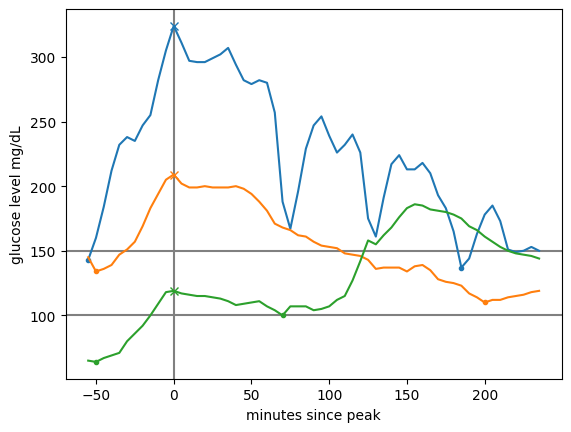

In [13]:
# Plot the series around detected events

if df_events.shape[0] == 0:
    print("No events detected :(")
else:
    
    ax = plt.gca()

    ax.axhline(y = glucose_threshold_high, color = 'gray')
    ax.axhline(y = glucose_threshold_low, color = 'gray')
    ax.axvline(x = 0, color = 'gray')
    ax.set_ylabel('glucose level mg/dL')
    ax.set_xlabel('minutes since peak')
    
    for j, t0 in enumerate(df_events['peak_time']):
        
        x = lambda t : (t - t0)/timedelta(minutes=1)
        
        idx = (glucose_level_ts > t0-max_nadir_to_peak_time) & (glucose_level_ts < t0+max_peak_to_2nd_nadir_time)        
        line = ax.plot(x(glucose_level_ts[idx]),glucose_level[idx],label=t0)
        ax.plot(x(df_events.loc[j,'initial_nadir_time']),df_events.loc[j,'initial_nadir_glucose'],'.',color=line[0].get_color())
        ax.plot(x(df_events.loc[j,'secondary_nadir_time']),df_events.loc[j,'secondary_nadir_glucose'],'.',color=line[0].get_color())
        ax.plot(x(df_events.loc[j,'peak_time']),df_events.loc[j,'peak_glucose'],'x',color=line[0].get_color())

    #ax.legend()    
    plt.show()

In [ ]:
# Convert data to numpy arrays
glucose_level_ts = np.array(data['glucose_level_ts'])
glucose_level = np.array(data['glucose_level_mg/dL'], dtype=float)
glucose_change = np.array(data['BG Rate of Change'], dtype=float)

# Set threshold values for glycemic events
glucose_threshold_high = 100  # mg/dL (5.5 mmol/L)
glucose_threshold_low = 100 # mg/dL (5.5 mmol/L)
rate_of_change_threshold = 3.6  # mg/dL/min (0.3 mmol/L)

# Initialize lists to store event data
event_nadir = []
event_peak = []
event_secondary_nadir = []
event_time_nadir = []
event_time_peak = []
event_time_secondary_nadir = []

# Loop through the data to find events
# Find peak of the event
# Check for initial nadir event
for i in range(1, len(glucose_level) - 1):
    if glucose_level[i] < glucose_threshold_low and (glucose_level[i - 1] - glucose_level[i]) > rate_of_change_threshold and (glucose_level[i + 1] - glucose_level[i]) > rate_of_change_threshold:
        # Check that the event occurred within the time threshold
        #if len(event_time_peak) > 0 and glucose_level_ts[i] - event_time_peak[-1] < time_threshold:
        # Found a nadir event
        if len(event_nadir) == 0 or (glucose_level[i], glucose_level_ts[i]) != (event_nadir[-1], event_time_nadir[-1]):
            event_nadir.append(glucose_level[i])
            event_time_nadir.append(glucose_level_ts[i])

for j in range(len(glucose_level) - 1):
    if glucose_level[j] > glucose_threshold_high and (glucose_level[j] - glucose_level[j - 1]) > rate_of_change_threshold and (glucose_level[j] - glucose_level[j + 1]) > rate_of_change_threshold:
        # Check that the event occurred within the time threshold
        # if len(event_time_nadir) > 0 and glucose_level_ts[j] - event_time_nadir[-1] < time_threshold:
        time_since_nadir = glucose_level_ts[j] - event_time_nadir[-1]
        if time_since_nadir.astype('timedelta64[s]').astype(int) >= 3600:  
            # check if time since last nadir event is >= 1 hour# Found a peak event
            event_peak.append(glucose_level[j])
            event_time_peak.append(glucose_level_ts[j])
        
# Check for a secondary nadir event
for k in range(len(glucose_level) - 1):
    if glucose_level[k] < glucose_level[k - 1] and (glucose_level[k - 1] - glucose_level[k]) > rate_of_change_threshold and (glucose_level[k + 1] - glucose_level[k]) > rate_of_change_threshold and glucose_level_ts[k] > event_time_peak[-1]:
        # Check that the event occurred within the time threshold
        #if len(event_time_secondary_nadir) > 0 and glucose_level_ts[k] - event_time_peak[-1] < time_threshold:
        time_since_peak = glucose_level_ts[k] - event_time_peak[-1]
        if time_since_peak.astype('timedelta64[s]').astype(int) >= 14400:   # check if time since last peak event is >= 4 hours
            # Found a secondary nadir event
            event_secondary_nadir.append(glucose_level[k])
            event_time_secondary_nadir.append(glucose_level_ts[k])

print('Event nadir:', event_nadir , event_time_nadir)
print('Event peak:', event_peak, event_time_peak)
print('Event Secondary nadir:', event_secondary_nadir, event_time_secondary_nadir)

In [ ]:
# Initialize events list
events = []

# Loop through the events in the 24 hour period
num_events_per_day = []
start_date = data['glucose_level_ts'].iloc[0].date()
end_date = data['glucose_level_ts'].iloc[-1].date()
delta = datetime.timedelta(days=1)
while start_date <= end_date:
    events_in_period = 0
    for i in range(len(event_time_peak)):
        event_date = event_time_peak[i].date()
        if event_date == start_date:
            events_in_period += 1
    num_events_per_day.append(events_in_period)
    start_date += delta

# Loop through all events
for i in range(len(event_peak)):
    initial_nadir = None
    secondary_nadir = None

    # Find the initial nadir event that occurred before the peak event
    for j in range(len(event_nadir)):
        if event_time_nadir[j] < event_time_peak[i]:
            initial_nadir = (event_nadir[j], event_time_nadir[j])
        
    # Find the secondary nadir event that occurred after the peak event
    for k in range(len(event_secondary_nadir)):
        if event_time_secondary_nadir[k] > event_time_peak[i]:
            secondary_nadir = (event_secondary_nadir[k], event_time_secondary_nadir[k])
    
    # Calculate the positive and negative glucose excursions
    positive_excursion = event_peak[i] - initial_nadir[0] if initial_nadir is not None else None
    negative_excursion = event_peak[i] - secondary_nadir[0] if secondary_nadir is not None else None

    # Add the event to the events list
    initial_nadir_glucose = initial_nadir[0] if initial_nadir is not None else None
    initial_nadir_time = initial_nadir[1] if initial_nadir is not None else None
    peak_glucose = event_peak[i]
    peak_time = event_time_peak[i]
    secondary_nadir_glucose = secondary_nadir[0] if secondary_nadir is not None else None
    secondary_nadir_time = secondary_nadir[1] if secondary_nadir is not None else None
    events.append((initial_nadir_glucose, initial_nadir_time, peak_glucose, peak_time, secondary_nadir_glucose, secondary_nadir_time, positive_excursion, negative_excursion))

# Create a pandas dataframe from the events list
df_events = pd.DataFrame(events, columns=['initial_nadir_glucose', 'initial_nadir_time', 'peak_glucose', 'peak_time', 'secondary_nadir_glucose', 'secondary_nadir_time', 'positive_excursion', 'negative_excursion'])
df_events.head()

Step 3:

Calculate glucose appreance and disappearance rates

    a. Glucose excursion (mmol/L.min-1)
    
    b. iAUC

Step 4. 

Total change in BG (nadir to peak / peak to nadir) - +ve and -ve 

In [ ]:
# Calculate iAUC for positive and negative excursions
positive_iAUC = []
negative_iAUC = []

for i in range(len(df_events)):
    # Get glucose levels for the positive and negative excursions
    initial_nadir_glucose = df_events.loc[i, 'initial_nadir_glucose']
    peak_glucose = df_events.loc[i, 'peak_glucose']
    secondary_nadir_glucose = df_events.loc[i, 'secondary_nadir_glucose']
    
    positive_glucose = np.arange(initial_nadir_glucose, peak_glucose)
    negative_glucose = np.arange(peak_glucose, secondary_nadir_glucose)
    
    # Calculate iAUC for positive excursion
    positive_iAUC.append(np.trapz(positive_glucose))
    
    # Calculate iAUC for negative excursion
    negative_iAUC.append(np.trapz(negative_glucose))

# Add columns to DataFrame
df_events['positive_iAUC'] = positive_iAUC
df_events['negative_iAUC'] = negative_iAUC


df_events.head()

,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,positive_excursion,negative_excursion,positive_iAUC,negative_iAUC
0,77.0,2020-04-07 13:37:00,229.0,2020-11-05 20:29:00,219.0,2020-12-06 19:49:00,152.0,10.0,23027.5,0.0
1,77.0,2020-04-07 13:37:00,233.0,2020-11-05 21:29:00,219.0,2020-12-06 19:49:00,156.0,14.0,23947.5,0.0
2,77.0,2020-04-07 13:37:00,152.0,2020-12-05 00:59:00,219.0,2020-12-06 19:49:00,75.0,-67.0,8436.0,12210.0
3,77.0,2020-04-07 13:37:00,153.0,2020-12-05 02:19:00,219.0,2020-12-06 19:49:00,76.0,-66.0,8587.5,12057.5
4,77.0,2020-04-07 13:37:00,172.0,2020-12-05 02:34:00,219.0,2020-12-06 19:49:00,95.0,-47.0,11656.0,8970.0


Identify the carbohydrate intake and timestamps

In [ ]:
#unfiltered.head()

,glucose_level_ts,glucose_level_mg/dL,glucose_level_mmol/L,carbs_g,meal_ts,meal_type,bolus_dose,bolus_start_ts,bolus_end_ts,bolus_type,day_name,day_number,week_of_experiment,time_period
0,2020-11-05 00:02:00,129,NaN,135.0,11/05/2020 11:25,Lunch,7.1,11/05/2020 08:24,11/05/2020 08:24,normal,Thursday,4,45.0,Early Morning
1,2020-11-05 00:07:00,128,NaN,100.0,11/05/2020 17:16,Dinner,16.8,11/05/2020 11:24,11/05/2020 11:24,normal,Thursday,4,45.0,Early Morning
2,2020-11-05 00:12:00,129,NaN,42.0,11/05/2020 21:26,Snack,14.2,11/05/2020 17:19,11/05/2020 17:19,normal,Thursday,4,45.0,Early Morning
3,2020-11-05 00:17:00,131,NaN,37.0,12/05/2020 08:02,Breakfast,7.5,11/05/2020 21:23,11/05/2020 21:23,normal,Thursday,4,45.0,Early Morning
4,2020-11-05 00:22:00,133,NaN,78.0,12/05/2020 12:07,Lunch,6.9,12/05/2020 08:00,12/05/2020 08:00,normal,Thursday,4,45.0,Early Morning


Step 6. 

Collate the results of the above points into a data set with columns names

- Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)
- Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
- Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
- Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
- Time period Number (1 / 2 / 3 / 4 / 5)
- iAUC (+ve)
- iAUC (-ve)
- Glucose Excursion (+ve)
- Glucose Excursion (-ve)
- Total change in BG (+ve)
- Total change in BG (-ve)
- Peak value
- Carbs

In [ ]:
df_events['day_names'] = unfiltered['glucose_level_ts'].dt.day_name()
df_events['time_of_day'] = unfiltered['glucose_level_ts'].apply(lambda x: get_time_period(pd.to_datetime(x)))
df_events['day_number'] = unfiltered['glucose_level_ts'].dt.dayofweek + 1
df_events['week_of_experiment'] = np.ceil(unfiltered['glucose_level_ts'].dt.dayofyear / 7)
df_events['carbs_g'] = unfiltered['carbs_g']
#df_events['meal_ts'] = pd.to_datetime(unfiltered['meal_ts'])
df_events['meal_type'] = unfiltered['meal_type']

df_events.head()

,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,positive_excursion,negative_excursion,positive_iAUC,negative_iAUC,day_names,time_of_day,day_number,week_of_experiment,carbs_g,meal_type
0,77.0,2020-04-07 13:37:00,229.0,2020-11-05 20:29:00,219.0,2020-12-06 19:49:00,152.0,10.0,23027.5,0.0,Thursday,Early Morning,4,45.0,135.0,Lunch
1,77.0,2020-04-07 13:37:00,233.0,2020-11-05 21:29:00,219.0,2020-12-06 19:49:00,156.0,14.0,23947.5,0.0,Thursday,Early Morning,4,45.0,100.0,Dinner
2,77.0,2020-04-07 13:37:00,152.0,2020-12-05 00:59:00,219.0,2020-12-06 19:49:00,75.0,-67.0,8436.0,12210.0,Thursday,Early Morning,4,45.0,42.0,Snack
3,77.0,2020-04-07 13:37:00,153.0,2020-12-05 02:19:00,219.0,2020-12-06 19:49:00,76.0,-66.0,8587.5,12057.5,Thursday,Early Morning,4,45.0,37.0,Breakfast
4,77.0,2020-04-07 13:37:00,172.0,2020-12-05 02:34:00,219.0,2020-12-06 19:49:00,95.0,-47.0,11656.0,8970.0,Thursday,Early Morning,4,45.0,78.0,Lunch


In [ ]:
# Save the DataFrame to a CSV file

file_path = '/Users/user/Desktop/Clustering Project/CSV Files/544_clustering_data.csv'

df_events.to_csv(path_or_buf=file_path, index=False)